In [2]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import pandas as pd

Seating order for 400 students: tensor([[227., 326.,  72.,  59.,  36., 183., 112., 162., 160., 330.],
        [296., 273., 388., 174., 153., 246., 297., 105.,  62., 137.],
        [ 53., 202., 107., 195., 148., 348., 216., 171., 337., 176.],
        [116.,  47., 158., 269., 290., 247., 318., 198., 300., 338.],
        [ 40., 314., 113.,  32.,  91., 201., 250., 289., 389., 306.],
        [129., 182.,  60., 381., 140., 127.,  12., 350., 173.,  95.],
        [356., 240., 287.,  77., 180., 184., 141.,  43., 362.,  57.],
        [238., 189.,   7., 257., 111., 372., 155., 263.,   0., 264.],
        [299., 361., 143.,  63.,  24., 317.,  46., 339.,  97., 136.],
        [275., 384.,  87., 358., 159., 108., 117., 252., 156.,  28.],
        [243., 281.,  99., 336., 371., 346., 254., 344.,  49., 302.],
        [256., 334.,  39.,  21., 394., 211., 245.,   8., 230.,  50.],
        [332., 278., 231., 276., 251., 226., 370., 294., 199., 239.],
        [323.,   2.,  13., 249., 303., 366.,  81.,  64., 3

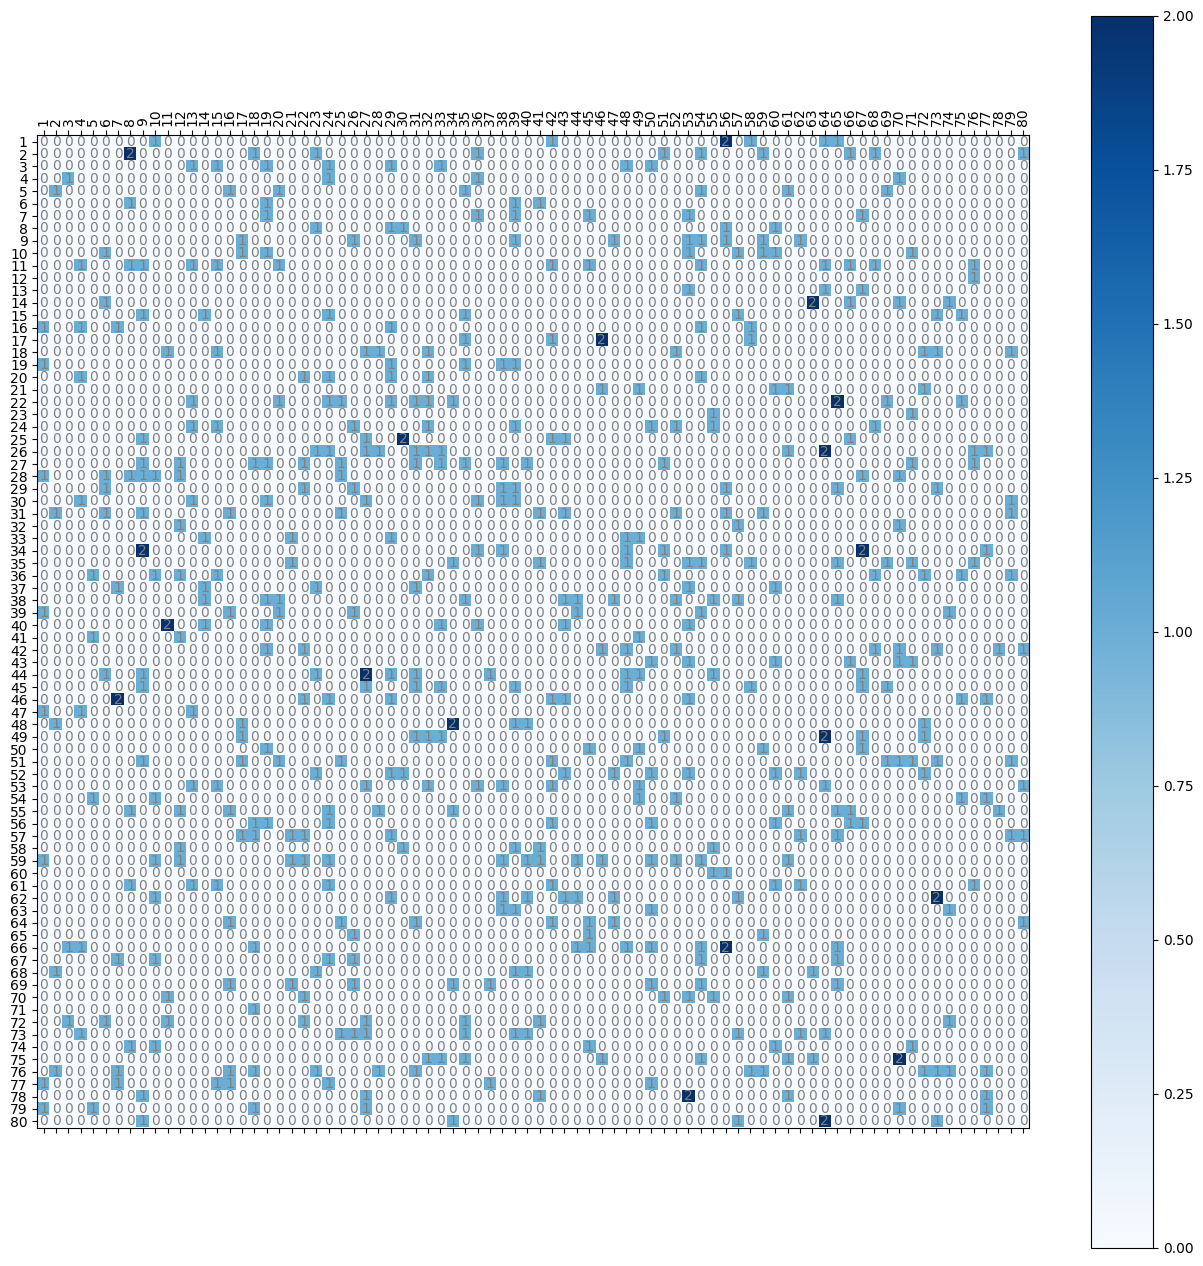

40x2 shuffled groups matrix: tensor([[40, 25],
        [44, 10],
        [14, 49],
        [29, 23],
        [24, 34],
        [18, 42],
        [13,  3],
        [50, 11],
        [ 1, 26],
        [15, 66],
        [53, 19],
        [65, 36],
        [ 2, 67],
        [33, 51],
        [45, 32],
        [79,  5],
        [37, 54],
        [31, 38],
        [60, 63],
        [77, 16],
        [30, 75],
        [41, 74],
        [47, 22],
        [69, 70],
        [73, 39],
        [64, 62],
        [ 7, 78],
        [28,  4],
        [58, 59],
        [ 8, 17],
        [ 9, 43],
        [35, 55],
        [48, 76],
        [72, 71],
        [46,  6],
        [57, 27],
        [68,  0],
        [56, 20],
        [12, 52],
        [21, 61]])
Analysis of adjacent group relationships: tensor([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [2., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 0.],
        [0., 1.],
        [2

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Constants for group count and seating dimensions
num_groups = 80
num_students = 400
rows, cols = 40, 10

class SeatingNet(nn.Module):
    def __init__(self):
        super(SeatingNet, self).__init__()
        self.fc1 = nn.Linear(num_groups, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_groups)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = self.fc4(out)
        return out

# Instantiate the model
model = SeatingNet()

def penalty_loss(prediction, conflict_matrix):
    probabilities = torch.softmax(prediction, dim=1).reshape(num_groups)

    penalty = 0
    for i in range(num_groups - 1):
        for j in range(i + 1, num_groups - 1):
            if conflict_matrix[i, j] == 1:
                penalty += probabilities[i] * probabilities[j]

    return penalty

# Define optimizer
optimizer = optim.Adam(model.parameters())

class SeatingArrangementV2:
    def __init__(self, num_people, row_count, col_count):
        self.num_people = num_people
        self.row_count = row_count
        self.col_count = col_count
        self.seating_order = self._create_seating_order()
        self.groups = self._form_groups()
        self.group_matrix = self._shuffle_groups_to_matrix()
        self.person_conflict_matrix = None
        self.group_conflict_matrix = None

    def _create_seating_order(self):
        people_ids = list(range(self.num_people))
        random.shuffle(people_ids)

        seating_order = torch.zeros(self.row_count, self.col_count)
        idx = 0
        for r in range(self.row_count):
            for c in range(self.col_count):
                seating_order[r, c] = people_ids[idx]
                idx += 1

        return seating_order.float()

    def _form_groups(self):
        group_size = 5
        group_list = [
            self.seating_order[r][c:c+group_size]
            for r in range(self.seating_order.shape[0])
            for c in range(0, self.seating_order.shape[1], group_size)
        ]
        return {i: grp.tolist() for i, grp in enumerate(group_list)}

    def _shuffle_groups_to_matrix(self):
        group_ids = list(self.groups.keys())
        random.shuffle(group_ids)

        group_tensor = torch.tensor(group_ids)
        return group_tensor.reshape((self.row_count, self.col_count // 5))

    def _find_group(self, person_id):
        for group_id, group in self.groups.items():
            if person_id in group:
                return group_id
        return -1

    def generate_person_conflict_matrix(self):
        conflict_matrix = torch.zeros(self.num_people, self.num_people)
        conflicts_added = 0
        conflict_pairs = []

        while conflicts_added < 600:
            a, b = random.randint(0, self.num_people - 1), random.randint(0, self.num_people - 1)
            group_a, group_b = self._find_group(a), self._find_group(b)

            if group_a != group_b and conflict_matrix[a][b] == 0:
                conflict_matrix[a][b] = 1
                conflicts_added += 1
                conflict_pairs.append((a, b))

        self.person_conflict_matrix = conflict_matrix.float()
        return conflict_pairs

    def generate_group_conflict_matrix(self):
        conflict_matrix = torch.zeros(len(self.groups), len(self.groups))

        for group_a, members_a in self.groups.items():
            for group_b, members_b in self.groups.items():
                if group_a != group_b:
                    conflict_sum = sum(
                        self.person_conflict_matrix[int(a), int(b)]
                        for a in members_a
                        for b in members_b
                    )
                    conflict_matrix[group_a, group_b] = conflict_sum

        self.group_conflict_matrix = conflict_matrix
        return self.group_conflict_matrix

    def analyze_adjacent_group_conflicts(self):
        adjacent_conflict_matrix = torch.zeros(self.row_count, self.col_count // 5)

        for r in range(self.row_count):
            for c in range(self.col_count // 5):
                group = self.group_matrix[r, c]
                if r > 0:
                    adjacent_conflict_matrix[r, c] += self.group_conflict_matrix[group, self.group_matrix[r - 1, c]]
                if r < self.row_count - 1:
                    adjacent_conflict_matrix[r, c] += self.group_conflict_matrix[group, self.group_matrix[r + 1, c]]
                if c > 0:
                    adjacent_conflict_matrix[r, c] += self.group_conflict_matrix[group, self.group_matrix[r, c - 1]]
                if c < self.col_count // 5 - 1:
                    adjacent_conflict_matrix[r, c] += self.group_conflict_matrix[group, self.group_matrix[r, c + 1]]

        return adjacent_conflict_matrix

    def identify_conflict_pairs(self, adjacent_conflict_matrix):
        return [
            (r, c) for r in range(adjacent_conflict_matrix.shape[0])
            for c in range(adjacent_conflict_matrix.shape[1])
            if adjacent_conflict_matrix[r, c] != 0
        ]

    def extract_conflicted_groups(self, conflict_pairs):
        return [int(self.group_matrix[r, c]) for r, c in conflict_pairs]

    def resolve_conflicts(self, conflict_pairs, conflicted_groups):
        for coord, group_id in zip(conflict_pairs, conflicted_groups):
            r, c = coord
            self.group_matrix[r, c] = group_id
        return self.group_matrix

    def update_conflict_analysis(self, new_matrix):
        return self.analyze_adjacent_group_conflicts()

    def display_conflict_matrix(self):
        fig, ax = plt.subplots(figsize=(16, 16))
        cax = ax.matshow(self.group_conflict_matrix, cmap='Blues')
        fig.colorbar(cax)
        ax.set_xticks(range(len(self.group_conflict_matrix)))
        ax.set_yticks(range(len(self.group_conflict_matrix)))
        ax.set_xticklabels(range(1, len(self.group_conflict_matrix) + 1))
        ax.set_yticklabels(range(1, len(self.group_conflict_matrix) + 1))
        plt.xticks(rotation=90)

        for i in range(len(self.group_conflict_matrix)):
            for j in range(len(self.group_conflict_matrix)):
                ax.text(j, i, int(self.group_conflict_matrix[i, j].item()), ha="center", va="center", color='gray')

        plt.show()

# Metrics functions
def count_conflicts(conflict_matrix):
    return torch.sum(conflict_matrix).item()

def average_conflict_score(conflict_matrix):
    group_conflicts = conflict_matrix[conflict_matrix > 0]
    if len(group_conflicts) == 0:
        return 0
    return torch.mean(group_conflicts).item()

# Example usage:
seating_manager = SeatingArrangementV2(num_students, rows, cols)

seating_order = seating_manager.seating_order
print('Seating order for 400 students:', seating_order)

person_conflicts = seating_manager.generate_person_conflict_matrix()
print('Incompatible persons in 400x400 matrix:', person_conflicts)

student_groups = seating_manager.groups
print('Groups of 5 students:', student_groups)

group_conflicts = seating_manager.generate_group_conflict_matrix()
print('Incompatible groups in 80x80 matrix:', group_conflicts)
seating_manager.display_conflict_matrix()

group_matrix = seating_manager.group_matrix
print('40x2 shuffled groups matrix:', group_matrix)

adjacent_conflicts = seating_manager.analyze_adjacent_group_conflicts()
print('Analysis of adjacent group relationships:', adjacent_conflicts)

# Initialize metrics storage
epoch_conflict_counts = []
epoch_average_scores = []
epoch_losses = []

for epoch in range(20):
    if epoch != 0:
        for key in student_groups:
            random.shuffle(student_groups[key])

        group_conflicts = seating_manager.generate_group_conflict_matrix()
        print('Incompatible groups in 80x80 matrix:', group_conflicts)

        adjacent_conflicts = seating_manager.analyze_adjacent_group_conflicts()
        print('Analysis of adjacent group relationships:', adjacent_conflicts)

        conflict_pairs = seating_manager.identify_conflict_pairs(adjacent_conflicts)
        print('Pairs of indices in conflict matrix groups:', conflict_pairs)

        conflicted_groups = seating_manager.extract_conflicted_groups(conflict_pairs)
        print('Groups with conflicts:', conflicted_groups)

        if len(conflicted_groups) in {0, 1}:
            zero_matrix = torch.zeros(num_students, num_students)
            final_group_list = []

            for r in range(group_matrix.shape[0]):
                for c in range(group_matrix.shape[1]):
                    group_id = group_matrix[r, c]
                    group_members = student_groups[int(group_id)]
                    final_group_list.append(group_members)

            final_group_tensor = torch.tensor(final_group_list)
            final_group_matrix = final_group_tensor.reshape((rows, cols))
            print('Final arrangement:', final_group_matrix)
            break

        random.shuffle(conflicted_groups)

        new_group_matrix = seating_manager.resolve_conflicts(conflict_pairs, conflicted_groups)
        print('New generated seating order for groups:', new_group_matrix)

        updated_conflict_matrix = seating_manager.update_conflict_analysis(new_group_matrix)
        print('Updated conflict analysis for groups:', updated_conflict_matrix)

        if len(conflicted_groups) == 2 and torch.sum(updated_conflict_matrix == 1) == 2:
            if loss_value < 1.000000e-06:
                break

        group_matrix = new_group_matrix
        adjacent_conflicts = updated_conflict_matrix

    # Predict seating probabilities for each student
    output = model(torch.FloatTensor(adjacent_conflicts).view(-1, rows * (cols // 5)))

    loss_value = penalty_loss(output, group_conflicts)
    prev_loss = loss_value

    # Zero out gradients
    optimizer.zero_grad()

    # Compute gradients
    loss_value.backward()

    # Update model parameters
    optimizer.step()

    # Display loss
    print(f"Epoch {epoch + 1}: loss = {loss_value.item():.7f}")

    # Calculate and store metrics
    epoch_conflict_counts.append(count_conflicts(group_conflicts))
    epoch_average_scores.append(average_conflict_score(group_conflicts))
    epoch_losses.append(loss_value.item())


